# **Pre-processing**

In [1]:
# Note: refer to https://www.kaggle.com/discussions/general/74235

from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip -o face-expression-recognition-dataset.zip -d face_expression_dataset

Streaming output truncated to the last 5000 lines.
  inflating: face_expression_dataset/images/validation/fear/8797.jpg  
  inflating: face_expression_dataset/images/validation/fear/8818.jpg  
  inflating: face_expression_dataset/images/validation/fear/886.jpg  
  inflating: face_expression_dataset/images/validation/fear/9037.jpg  
  inflating: face_expression_dataset/images/validation/fear/9040.jpg  
  inflating: face_expression_dataset/images/validation/fear/9101.jpg  
  inflating: face_expression_dataset/images/validation/fear/911.jpg  
  inflating: face_expression_dataset/images/validation/fear/9179.jpg  
  inflating: face_expression_dataset/images/validation/fear/9205.jpg  
  inflating: face_expression_dataset/images/validation/fear/9232.jpg  
  inflating: face_expression_dataset/images/validation/fear/9251.jpg  
  inflating: face_expression_dataset/images/validation/fear/9261.jpg  
  inflating: face_expression_dataset/images/validation/fear/9281.jpg  
  inflating: face_expression

In [2]:
# Install required packages if not already installed
!pip install torch torchvision --quiet

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import convolve2d, correlate2d
import math
from torch.utils.data import ConcatDataset, random_split


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.9 MB/s eta 0:00:00


In [3]:
transform=transforms.Compose([
          transforms.Resize ((224,224)),
          transforms.Grayscale(num_output_channels=1),
          transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.GaussianBlur(kernel_size=3, sigma=(0.1,2.0)),
          transforms.RandomRotation(degrees=15),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5], std=[0.5]),
])

full_train = datasets.ImageFolder(root='face_expression_dataset/images/train',transform=transform)
val_set = datasets.ImageFolder('face_expression_dataset/images/validation',transform=transform)
combined=ConcatDataset([full_train,val_set])

test_size = int(0.1*len(combined))
trainval_size =len(combined)-test_size

trainval_set,test_set = random_split(combined,[trainval_size,test_size],
                                  generator=torch.Generator().manual_seed(42))
val_size =int(0.1*len(trainval_set))
train_size=len(trainval_set)-val_size
train_set, val_set=random_split(
    trainval_set,
    [train_size,val_size],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(trainval_set, batch_size=64, shuffle=True)
val_loader=DataLoader(val_set,batch_size=64)
test_loader=DataLoader(test_set, batch_size=64)

In [4]:
train_dataset =datasets.ImageFolder('face_expression_dataset/images/train',transform=transform)
print(train_dataset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
print("Total combined size:", len(combined))

Total combined size: 35887


In [6]:
print(f"Train set size: {len(train_set)}")
print(f"Validation set size:{len(val_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 29070
Validation set size:3229
Test set size: 3588


In [7]:
images,labels=next(iter(train_loader)) #check one batch
print("Check Image batch shape:",images.shape)
print("Label batch shape:",labels.shape)
print("First label in batch:",labels[0])

Check Image batch shape: torch.Size([64, 1, 224, 224])
Label batch shape: torch.Size([64])
First label in batch: tensor(3)


# **Model Def**

In [8]:
# define function objects for each activation function
def relu(x):
  return np.maximum(0, x)

def sigmoid(x):
  return 1/(1+np.exp(-x))

def tanh(x):
  return np.tanh(x)

def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x/e_x.sum()

def identity(x):
  return x

In [9]:
# define funnction objects for each of the derivates
def relu_prime(x):
  return (x>=0).astype(int)

def sigmoid_prime(x):
  return sigmoid(x) * (1 - sigmoid(x))

def tanh_prime(x):
  return (1/np.cosh(x))^2

# note: not used
def softmax_prime(x):
  return np.diag(softmax(x)) - np.outer(softmax(x), softmax(x))

def identity_prime(x):
  return np.full_like(x, 1)

In [10]:
# define dictionary pairing activation functions with their derivatives
prime_dict = {relu: relu_prime, sigmoid: sigmoid_prime, tanh: tanh_prime,
              softmax: softmax_prime, identity: identity_prime}

In [11]:
# Class representing a full cnn layer

class conv_layer:
  def __init__(self, input_size = 48, num_kernels = 16, kernel_size = 2, depth = 1, padding = 'valid'):
    # initialize attributes
    self.input_size = input_size
    self.num_kernels = num_kernels
    self.kernel_size = kernel_size
    self.depth = depth
    self.padding = padding
    if padding == 'valid':
      self.output_size = input_size - kernel_size + 1
    if padding == 'same':
      self.output_size = input_size

    self.input_shape = (self.input_size, self.input_size, self.depth)
    self.output_shape = (self.output_size, self.output_size, self.num_kernels)

    # create list of num_kernels-many arrays of size kernel_size x kernel_size
    # initialized with standard normal distribution
    # kernels[ :, :, i, j] is the i'th kernel for the j'th input channel
    self.kernels = np.random.normal(loc = 0, scale = math.sqrt(2/input_size), size = (self.kernel_size, self.kernel_size, self.num_kernels, self.depth))

    # biases[: , :, i] is the bias paired with the i'th kernel
    self.biases = np.random.normal(loc = 0, scale = math.sqrt(2/input_size), size = (self.output_size, self.output_size, self.num_kernels))

  def forward_pass(self, image):
    # record input for the purposes of backward pass
    self.input = image

    # intialize output array
    output = np.full((self.output_size, self.output_size, self.num_kernels), 0.0)

    # for each input channel
    for i in range(self.num_kernels):
      # perform the convolution
      bias = np.copy(self.biases[: ,: , i])
      output[:, :, i] = bias
      for j in range(self.depth):
        kernel = self.kernels[ :, :, i, j]
        output[:, :,i] += correlate2d(image[:,:,j], kernel, mode = self.padding)

    # record output for the purposes of backward pass
    self.output = output

    # return result
    return output

  def backward_pass(self, dE_dout):
    if dE_dout.shape != self.output_shape:
      print("Conv: Invalid shape")
      print(f"Expected {self.output_shape}, Received {dE_dout.shape}")

    # initialize gradients
    dE_dkernels = np.zeros_like(self.kernels)
    dE_dbiases = np.zeros_like(self.biases)
    dE_din = np.zeros((self.input_size, self.input_size, self.depth))

    # compute gradient wrt kernels
    for j in range(self.depth):
      for i in range(self.num_kernels):
        dE_dkernels[:, :, i, j] = correlate2d(self.input[:,:,j], dE_dout[:,:,i], mode = 'valid')

    # compute gradient wrt biases
    dE_dbiases = dE_dout

    # compute gradient wrt input
    for j in range(self.depth):
      for i in range(self.num_kernels):
        dE_din[:,:, j] += convolve2d(dE_dout[:,:,i], self.kernels[:,:,i,j], mode = 'full')

    return dE_dkernels, dE_dbiases, dE_din

In [12]:
# class for maxpool2d layer
# Note: only uses pool_size = 2 and stride = 2
# If input image does not have even dimensions, then last col/row is cropped
# e.g. (2k+1, 2k+1, M) becomes (k, k, M)

class maxpool2d_layer:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    N = self.input_shape[0]
    M = self.input_shape[-1]
    self.output_shape = (N//2, N//2, M)

  def forward_pass(self, x):
    N = x.shape[0]
    M = x.shape[-1]

    # Crop image in case of odd dimensions
    x_crop = x[:(N//2)*2, :(N//2)*2, :]
    self.input = x_crop

    # Reshape into (output_N, pool_size, output_N, pool_size, M)
    reshaped = x_crop.reshape(N//2, 2, N//2, 2, M)

    # Max over the pool_size axes (1 and 3)
    return reshaped.max(axis = (1, 3))

  def backward_pass(self, dE_dout):
    if dE_dout.shape != self.output_shape:
      print("Maxpool2D: Invalid shape")
      print(f"Received {dE_dout.shape}, expected {self.output_shape}")
      pass

    x = self.input
    N = x.shape[0]
    M = x.shape[-1]
    dE_dinput = np.zeros_like(x)

    for m in range(M):
      for i in range(0, N, 2):
        for j in range(0, N, 2):
          window = x[i:i+2, j:j+2, m]
          dE_dinput[i:i+2, j:j+2, m] = (window == np.max(window)) * dE_dout[int(i/2), int(j/2), m]

    return dE_dinput


In [13]:
# class for flatten layer

class flatten_layer:
  def __init__(self, input_shape):

    self.input_shape = input_shape
    self.output_shape = np.prod(input_shape)

  def forward_pass(self, x):
    self.input = x.reshape(-1)
    return x.reshape(-1,)

  def backward_pass(self, dE_dout):
    return np.reshape(dE_dout, self.input_shape)

In [14]:
# Class representing dense layer at the end used for classification

class dense_layer:
  def __init__(self, input_size, output_size, activation = relu):
    # initialize attributes
    self.input_size = input_size
    self.output_size = output_size
    self.activation = activation
    self.activation_prime = prime_dict[self.activation]

    # initialize weights of edges with standard normal
    # Note: w_{ji} is weight of edge from z_i in previous layer to a_j in current layer
    self.weights = np.random.standard_normal((output_size, input_size))
    self.bias = np.random.standard_normal((output_size))

    self.input = np.zeros(input_size)

  def forward_pass(self, input):
    self.input = input
    a = self.weights @ input + self.bias
    z = self.activation(a)
    self.a = a
    self.z = z
    return z

  def backward_pass(self, dE_dout):
    # gradient wrt weights
    if self.activation != softmax:
      dE_dweights = (dE_dout * self.activation_prime(self.a)).reshape(-1,1) * self.input
    else:
      A = np.diag(self.z) - np.outer(self.z, self.z)
      dE_dweights = (A @ dE_dout).reshape(-1,1) * self.input

    # gradient wrt biases
    A = np.diag(self.z) - np.outer(self.z, self.z)
    dE_dbias = A @ dE_dout

    # gradient wrt input of layer
    dE_dinput = self.weights.T @ dE_dout

    return dE_dweights, dE_dbias, dE_dinput

In [15]:
# Class for the full CNN
# Note: this is hard-coded with the following architecture:
# conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d -> flatten -> dense -> dense

class model:
  def __init__(self, input_shape = (48,48,1), num_kernels_1 =16, kernel_size_1 = 5,
               num_kernels_2 = 32, kernel_size_2 = 5,
               num_kernels_3 = 64, kernel_size_3 = 5,
               hidden_dense_layer_width = 32, hidden_dense_layer_activation = softmax):
    # initialize attributes
    self.input_shape = input_shape
    self.output_size = 7

    self.num_kernels_1 = num_kernels_1
    self.num_kernels_2 = num_kernels_2
    self.num_kernels_3 = num_kernels_3

    self.kernel_size_1 = kernel_size_1
    self.kernel_size_2 = kernel_size_2
    self.kernel_size_3 = kernel_size_3

    self.hidden_dense_layer_width = hidden_dense_layer_width
    self.hidden_dense_layer_activation = hidden_dense_layer_activation

    # initialize the layers of the model
    N = input_shape[0]
    M = input_shape[-1]
    self.conv1 = conv_layer(input_size = N, num_kernels = num_kernels_1,
                            kernel_size = kernel_size_1, depth = M)

    N = N - kernel_size_1 + 1
    M = num_kernels_1
    self.maxpool1 = maxpool2d_layer(input_shape = (N,N,M))

    N = N//2
    self.conv2 = conv_layer(input_size = N, num_kernels = num_kernels_2,
                            kernel_size = kernel_size_2, depth = M)

    N = N - kernel_size_2 + 1
    M = num_kernels_2
    self.maxpool2 = maxpool2d_layer(input_shape = (N,N,M))

    N = N//2
    self.conv3 = conv_layer(input_size = N, num_kernels = num_kernels_3,
                            kernel_size = kernel_size_3, depth = M)

    N = N - kernel_size_3 + 1
    M = num_kernels_3
    self.flatten = flatten_layer(input_shape = (N,N,M))

    N = np.prod((N,N,M))
    self.dense1 = dense_layer(input_size = N, output_size = hidden_dense_layer_width,
                              activation = relu)

    self.dense2 = dense_layer(input_size = hidden_dense_layer_width, output_size = 7,
                              activation = softmax)

  def forward_pass(self, x):
    # record most recent input for the purposes of backward_pass
    self.input = x

    # pass input through layers
    z1 = self.conv1.forward_pass(x)
    z2 = self.maxpool1.forward_pass(z1)
    z3 = self.conv2.forward_pass(z2)
    z4 = self.maxpool2.forward_pass(z3)
    z5 = self.conv3.forward_pass(z4)
    z6 = self.flatten.forward_pass(z5)
    z7 = self.dense1.forward_pass(z6)
    z8 = self.dense2.forward_pass(z7)

    return z8

  def backward_pass(self, dEn_dout):

    # perform backward pass along each of the layers and record returned gradients
    dEn_dweights2, dEn_dbias2, dEn_dout = self.dense2.backward_pass(dEn_dout)
    dEn_dweights1, dEn_dbias1, dEn_dout = self.dense1.backward_pass(dEn_dout)
    dEn_dout = self.flatten.backward_pass(dEn_dout)
    dEn_dkernels3, dEn_dbiases3, dEn_dout = self.conv3.backward_pass(dEn_dout)
    dEn_dout = self.maxpool2.backward_pass(dEn_dout)
    dEn_dkernels2, dEn_dbiases2, dEn_dout = self.conv2.backward_pass(dEn_dout)
    dEn_dout = self.maxpool1.backward_pass(dEn_dout)
    dEn_dkernels1, dEn_dbiases1, dE_ndout = self.conv1.backward_pass(dEn_dout)

    # return all gradients
    return dEn_dkernels1, dEn_dbiases1, dEn_dkernels2, dEn_dbiases2, dEn_dkernels3, dEn_dbiases3, dEn_dweights1, dEn_dbias1, dEn_dweights2, dEn_dbias2

  def predict(self, x):
    return np.argmax(self.forward_pass(x))

  def train(self, X_train, y_train, learning_rate, batch_size, epochs, epsilon = 0.01):
    for i in range(epochs):
      # print metrics epoch
      print(f"Current epoch: {i + 1}")

      # sample batches without replacement until training set is exhausted
      indices = np.arange(y_train.shape[0])
      np.random.shuffle(indices)
      num_batches = (y_train.shape[0]) // batch_size
      if y_train.size % batch_size != 0:
        num_batches += 1
      batches = []
      for j in range(num_batches):
        batches.append(indices[j * batch_size: (j+1)*batch_size])

      # for each batch, perform minibatch SGD
      batch_num = 0
      for batch in batches:
        batch_num += 1
        print(f'Current batch number: {batch_num}')
        # initialize arrays to store gradients
        dEbatch_dkernels1 = np.zeros_like(self.conv1.kernels)
        dEbatch_dbiases1 = np.zeros_like(self.conv1.biases)
        dEbatch_dkernels2 = np.zeros_like(self.conv2.kernels)
        dEbatch_dbiases2 = np.zeros_like(self.conv2.biases)
        dEbatch_dkernels3 = np.zeros_like(self.conv3.kernels)
        dEbatch_dbiases3 = np.zeros_like(self.conv3.biases)
        dEbatch_dweights1 = np.zeros_like(self.dense1.weights)
        dEbatch_dbias1 = np.zeros_like(self.dense1.bias)
        dEbatch_dweights2 = np.zeros_like(self.dense2.weights)
        dEbatch_dbias2 = np.zeros_like(self.dense2.bias)

        # for each sample in the batch
        for n in batch:
          # perform forward pass
          y_n = self.forward_pass(X_train[n])
          t_n = y_train[n]

          # compute dE_n/dy, i.e. gradient of loss wrt output y
          # Note: we project the denominator onto [epsilon, 1-epsilon] to prevent div by zero
          dEn_dy = -(t_n)/(np.maximum(y_n, epsilon))

          # perform backward pass to get gradient of loss wrt kernels/weights/biases
          gradients = self.backward_pass(dEn_dy)

          # add gradient associated with sample to gradient associated with sample
          dEbatch_dkernels1 += gradients[0]
          dEbatch_dbiases1 += gradients[1]
          dEbatch_dkernels2 += gradients[2]
          dEbatch_dbiases2 += gradients[3]
          dEbatch_dkernels3 += gradients[4]
          dEbatch_dbiases3 += gradients[5]
          dEbatch_dweights1 += gradients[6]
          dEbatch_dbias1 += gradients[7]
          dEbatch_dweights2 += gradients[8]
          dEbatch_dbias2 += gradients[9]

        # update weights by gradient descent
        self.conv1.kernels += - learning_rate * dEbatch_dkernels1
        self.conv1.biases += - learning_rate * dEbatch_dbiases1
        self.conv2.kernels += - learning_rate * dEbatch_dkernels2
        self.conv2.biases += - learning_rate * dEbatch_dbiases2
        self.conv3.kernels += - learning_rate * dEbatch_dkernels3
        self.conv3.biases += - learning_rate * dEbatch_dbiases3
        self.dense1.weights += - learning_rate * dEbatch_dweights1
        self.dense1.bias += - learning_rate * dEbatch_dbias1
        self.dense2.weights += - learning_rate * dEbatch_dweights2
        self.dense2.bias += - learning_rate * dEbatch_dbias2

# **Model Comparison**

Housekeeping and seeds, using GPU instead of CPU


In [16]:
import torch, random, numpy as np
torch.manual_seed(42); np.random.seed(42); random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', device)

Using cuda


### Model Definition (TinyCNN)


In [17]:
import torch.nn as nn
from torchvision.models import mobilenet_v2

class TinyCNN(nn.Module):
    def __init__(self, num_classes=7, in_ch=1):   # use 3 if your images are 3-channel
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),                    # 224 → 112
            nn.Conv2d(32,64,3,padding=1),  nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),                    # 112 → 56
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)                     # 56 → 28
        )
        self.pool = nn.AdaptiveAvgPool2d(1)      # always → (B,128,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)



### helpers for TinyCNN


In [18]:
def train_one_epoch(model, loader, loss_fn, optim, device):
    model.train()
    running = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optim.step()
        running += loss.item() * x.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    running, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        running += loss_fn(logits, y).item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return running / len(loader.dataset), correct / len(loader.dataset)


In [19]:
baseline = TinyCNN().to(device)
loss_fn  = nn.CrossEntropyLoss()
optim     = torch.optim.Adam(baseline.parameters(), lr=3e-4, weight_decay=1e-4)

best_acc = 0
for epoch in range(1, 11):
    tr_loss = train_one_epoch(baseline, train_loader, loss_fn, optim, device)
    val_loss, val_acc = evaluate(baseline, val_loader, loss_fn, device)
    print(f'E{epoch:02d}  train {tr_loss:.4f}  val {val_loss:.4f}  acc {val_acc:.3%}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(baseline.state_dict(), 'tinycnn_best.pth')
print('Best TinyCNN val-accuracy:', best_acc)

baseline.load_state_dict(torch.load("tinycnn_best.pth"))
baseline.eval()
test_loss, test_acc = evaluate(baseline, test_loader, loss_fn, device)
print(f"Final Test Accuracy: {test_acc:.2%}")

E01  train 1.7961  val 1.7668  acc 26.541%
E02  train 1.7797  val 1.7532  acc 28.027%
E03  train 1.7696  val 1.7488  acc 27.439%
E04  train 1.7642  val 1.7619  acc 27.532%
E05  train 1.7583  val 1.7439  acc 28.987%
E06  train 1.7534  val 1.7630  acc 26.448%
E07  train 1.7507  val 1.7367  acc 29.452%
E08  train 1.7475  val 1.7484  acc 28.399%
E09  train 1.7446  val 1.7177  acc 29.669%
E10  train 1.7395  val 1.7108  acc 30.814%
Best TinyCNN val-accuracy: 0.3081449365128523
Final Test Accuracy: 29.68%


# MobileNetV2 implementation (65% accuracy)


Running on cuda
Train  : 28821
Val    : 3533   (for tuning / early-stopping)
Test   : 3533      (held-out, never seen until final eval)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 109MB/s] 


E01  train_loss: 1.5345  val_loss: 1.3734  val_acc: 54.232%
E02  train_loss: 1.3531  val_loss: 1.3050  val_acc: 57.373%
E03  train_loss: 1.2960  val_loss: 1.2848  val_acc: 59.185%
E04  train_loss: 1.2592  val_loss: 1.2518  val_acc: 60.657%
E05  train_loss: 1.2275  val_loss: 1.2318  val_acc: 61.874%
E06  train_loss: 1.2020  val_loss: 1.2149  val_acc: 62.213%
E07  train_loss: 1.1813  val_loss: 1.2252  val_acc: 62.298%
E08  train_loss: 1.1631  val_loss: 1.2086  val_acc: 63.034%
E09  train_loss: 1.1408  val_loss: 1.2027  val_acc: 64.082%
E10  train_loss: 1.1265  val_loss: 1.1986  val_acc: 64.053%
E11  train_loss: 1.1126  val_loss: 1.1901  val_acc: 64.336%
E12  train_loss: 1.0984  val_loss: 1.1899  val_acc: 64.874%
E13  train_loss: 1.0920  val_loss: 1.1863  val_acc: 65.185%
E14  train_loss: 1.0838  val_loss: 1.1858  val_acc: 65.016%
E15  train_loss: 1.0864  val_loss: 1.1851  val_acc: 65.214%
Best validation accuracy: 0.652136994056043

FINAL TEST accuracy (never used for tuning): 65.157%


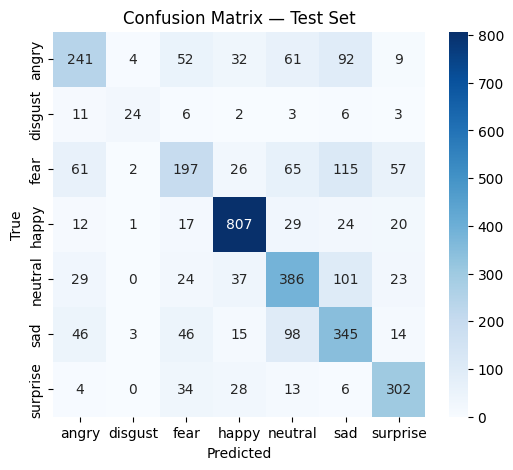

              precision    recall  f1-score   support

       angry       0.60      0.49      0.54       491
     disgust       0.71      0.44      0.54        55
        fear       0.52      0.38      0.44       523
       happy       0.85      0.89      0.87       910
     neutral       0.59      0.64      0.62       600
         sad       0.50      0.61      0.55       567
    surprise       0.71      0.78      0.74       387

    accuracy                           0.65      3533
   macro avg       0.64      0.60      0.61      3533
weighted avg       0.65      0.65      0.65      3533



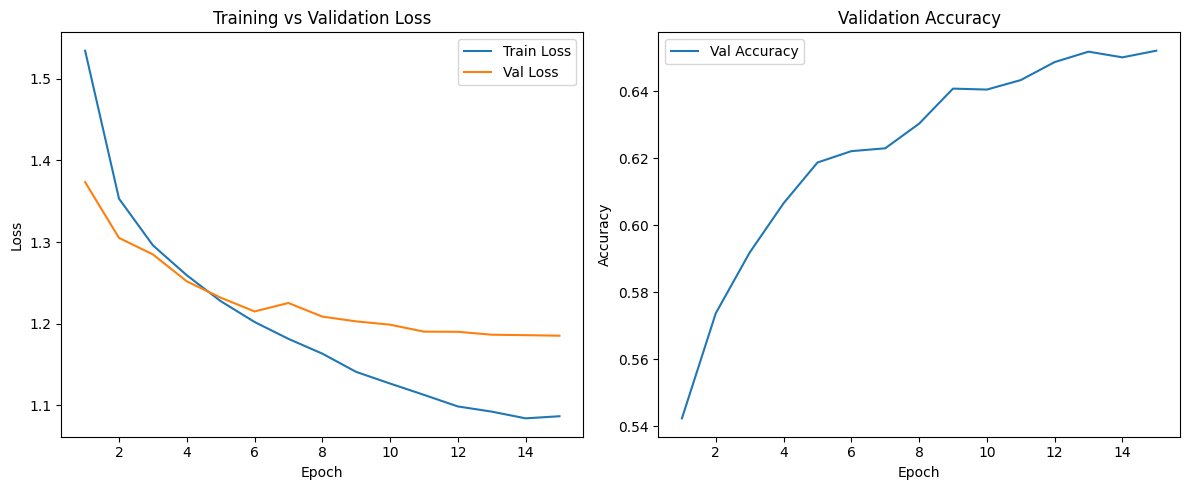

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split


# 1. Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on", device)

# 2. Transforms
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = '/content/face_expression_dataset/images/train'
val_dir   = '/content/face_expression_dataset/images/validation'

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tf)


#   • 50 % of the old validation data → NEW validation
#   • 50 % → independent test set

val_len  = len(val_ds)
test_len = val_len // 2
new_val_len = val_len - test_len      # keeps total sizes consistent

# fixed seed for reproducibility
generator = torch.Generator().manual_seed(42)
new_val_ds, test_ds = random_split(val_ds, [new_val_len, test_len],
                                   generator=generator)

# STEP B: rebuild loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=0, pin_memory=True)

val_loader   = DataLoader(new_val_ds, batch_size=64, shuffle=False,
                          num_workers=0, pin_memory=True)

test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"Train  : {len(train_ds)}")
print(f"Val    : {len(new_val_ds)}   (for tuning / early-stopping)")
print(f"Test   : {len(test_ds)}      (held-out, never seen until final eval)")


# 3. Model
model = mobilenet_v2(weights='DEFAULT')

# Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# Unfreeze last 4 blocks for fine-tuning
for name, p in model.named_parameters():
    if any(layer in name for layer in ['features.14', 'features.15', 'features.16', 'features.17']):
        p.requires_grad = True

# Replace classifier for 7 classes
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, len(train_ds.classes))
model = nn.Sequential(nn.Identity(), model).to(device)  # Identity: image already 3-channel

# 4. Helpers
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total += loss_fn(logits, y).item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return total / len(loader.dataset), correct / len(loader.dataset)

# 5. Training loop
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
train_losses, val_losses = [], []
val_accuracies = []
best_acc = 0
for epoch in range(1, 16):
    tr_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step()
    print(f'E{epoch:02d}  train_loss: {tr_loss:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.3%}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'mobile_best.pth')

print("Best validation accuracy:", best_acc)
model.load_state_dict(torch.load('mobile_best.pth'))   # best weights
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f"\nFINAL TEST accuracy (never used for tuning): {test_acc:.3%}")

# Confusion-matrix (optional, nice for the report)
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        preds = model(x.to(device)).argmax(1).cpu()
        y_true.extend(y.numpy()); y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — Test Set"); plt.show()

print(classification_report(y_true, y_pred, target_names=train_ds.classes))

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

 ### MobileNet hyperparameter tuning (change batch size, weight decay, learning weight)

Running on cuda
Train  : 28821
Val    : 3533   (for tuning / early-stopping)
Test   : 3533      (held-out, never seen until final eval)
E01  train_loss: 1.4739  val_loss: 1.3660  val_acc: 53.835%
E02  train_loss: 1.3091  val_loss: 1.2556  val_acc: 60.459%
E03  train_loss: 1.2530  val_loss: 1.2484  val_acc: 60.515%
E04  train_loss: 1.2193  val_loss: 1.2298  val_acc: 61.336%
E05  train_loss: 1.1891  val_loss: 1.2332  val_acc: 61.789%
E06  train_loss: 1.1671  val_loss: 1.2057  val_acc: 62.978%
E07  train_loss: 1.1390  val_loss: 1.1866  val_acc: 64.025%
E08  train_loss: 1.1165  val_loss: 1.1773  val_acc: 64.789%
Best validation accuracy: 0.6478913105009907

FINAL TEST accuracy (never used for tuning): 64.648%


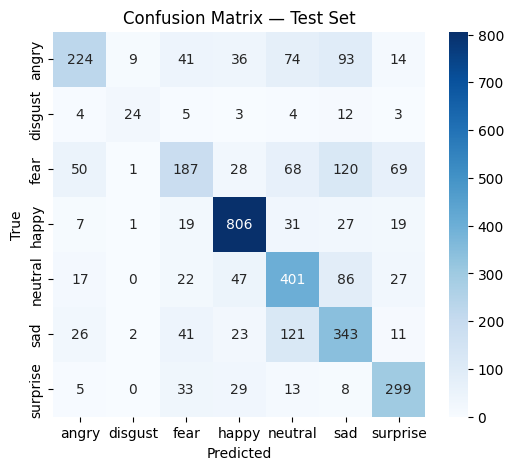

              precision    recall  f1-score   support

       angry       0.67      0.46      0.54       491
     disgust       0.65      0.44      0.52        55
        fear       0.54      0.36      0.43       523
       happy       0.83      0.89      0.86       910
     neutral       0.56      0.67      0.61       600
         sad       0.50      0.60      0.55       567
    surprise       0.68      0.77      0.72       387

    accuracy                           0.65      3533
   macro avg       0.63      0.60      0.60      3533
weighted avg       0.65      0.65      0.64      3533



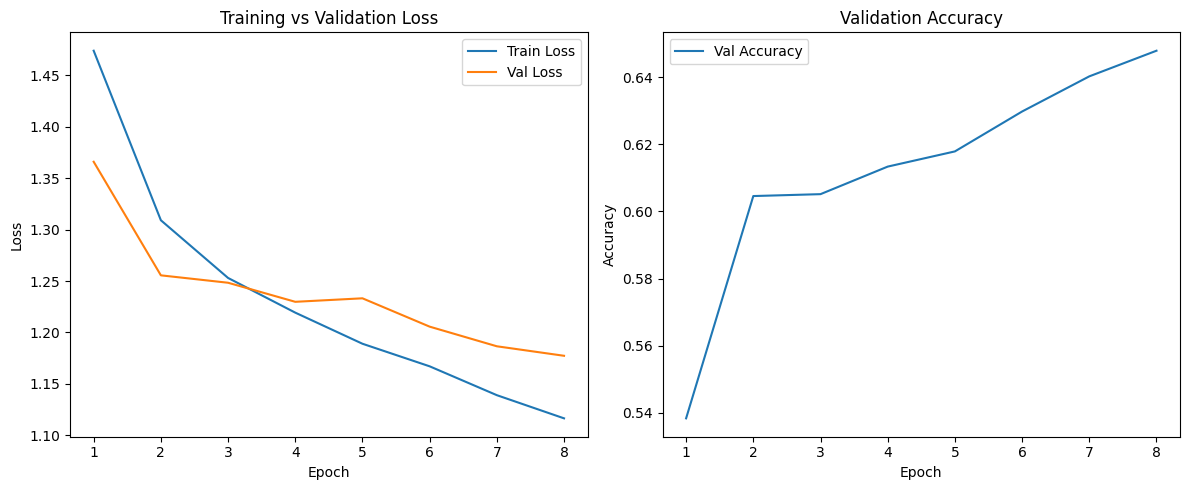

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split


# 1. Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on", device)

# 2. Transforms
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = '/content/face_expression_dataset/images/train'
val_dir   = '/content/face_expression_dataset/images/validation'

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tf)


#   • 50 % of the old validation data → NEW validation
#   • 50 % → independent test set

val_len  = len(val_ds)
test_len = val_len // 2
new_val_len = val_len - test_len      # keeps total sizes consistent

# fixed seed for reproducibility
generator = torch.Generator().manual_seed(42)
new_val_ds, test_ds = random_split(val_ds, [new_val_len, test_len],
                                   generator=generator)

# STEP B: rebuild loaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          num_workers=0, pin_memory=True)

val_loader   = DataLoader(new_val_ds, batch_size=128, shuffle=False,
                          num_workers=0, pin_memory=True)

test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"Train  : {len(train_ds)}")
print(f"Val    : {len(new_val_ds)}   (for tuning / early-stopping)")
print(f"Test   : {len(test_ds)}      (held-out, never seen until final eval)")


# 3. Model
model = mobilenet_v2(weights='DEFAULT')

# Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# Unfreeze last 4 blocks for fine-tuning
for name, p in model.named_parameters():
    if any(layer in name for layer in ['features.14', 'features.15', 'features.16', 'features.17']):
        p.requires_grad = True

# Replace classifier for 7 classes
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, len(train_ds.classes))
model = nn.Sequential(nn.Identity(), model).to(device)  # Identity: image already 3-channel

# 4. Helpers
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total += loss_fn(logits, y).item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return total / len(loader.dataset), correct / len(loader.dataset)

# 5. Training loop
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
train_losses, val_losses = [], []
val_accuracies = []
best_acc = 0
for epoch in range(1, 9):
    tr_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step()
    print(f'E{epoch:02d}  train_loss: {tr_loss:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.3%}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'mobile_best.pth')

print("Best validation accuracy:", best_acc)
model.load_state_dict(torch.load('mobile_best.pth'))   # best weights
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f"\nFINAL TEST accuracy (never used for tuning): {test_acc:.3%}")

# Confusion-matrix (optional, nice for the report)
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        preds = model(x.to(device)).argmax(1).cpu()
        y_true.extend(y.numpy()); y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — Test Set"); plt.show()

print(classification_report(y_true, y_pred, target_names=train_ds.classes))

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Further work: try out new model EfficientNet

Running on cuda
Train  : 28821
Val    : 3533   (for tuning / early-stopping)
Test   : 3533      (held-out, never seen until final eval)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 


E01  train_loss 1.4595  val_loss 1.2662  val_acc 59.383%
E02  train_loss 1.2369  val_loss 1.1700  val_acc 65.497%
E03  train_loss 1.1582  val_loss 1.1203  val_acc 68.129%
E04  train_loss 1.1061  val_loss 1.1085  val_acc 69.318%
E05  train_loss 1.0575  val_loss 1.0873  val_acc 70.082%
E06  train_loss 1.0177  val_loss 1.0835  val_acc 70.903%
E07  train_loss 0.9702  val_loss 1.0920  val_acc 70.167%
E08  train_loss 0.9336  val_loss 1.0946  val_acc 70.082%
Best val-accuracy: 0.7090291536937446
Classification Report:
               precision    recall  f1-score   support

       angry       0.63      0.64      0.64       469
     disgust       0.70      0.54      0.61        56
        fear       0.60      0.50      0.55       495
       happy       0.86      0.91      0.89       915
     neutral       0.67      0.65      0.66       616
         sad       0.57      0.59      0.58       572
    surprise       0.79      0.85      0.82       410

    accuracy                           0.71     

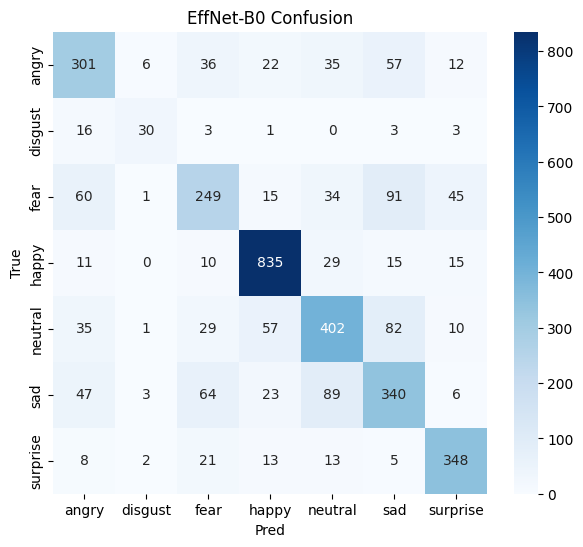

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from torchvision.models import efficientnet_b0



# 1. Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on", device)

# 2. Transforms
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = '/content/face_expression_dataset/images/train'
val_dir   = '/content/face_expression_dataset/images/validation'

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tf)


#   • 50 % of the old validation data → NEW validation
#   • 50 % → independent test set

val_len  = len(val_ds)
test_len = val_len // 2
new_val_len = val_len - test_len      # keeps total sizes consistent

# fixed seed for reproducibility
generator = torch.Generator().manual_seed(42)
new_val_ds, test_ds = random_split(val_ds, [new_val_len, test_len],
                                   generator=generator)

# STEP B: rebuild loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=0, pin_memory=True)

val_loader   = DataLoader(new_val_ds, batch_size=64, shuffle=False,
                          num_workers=0, pin_memory=True)

test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"Train  : {len(train_ds)}")
print(f"Val    : {len(new_val_ds)}   (for tuning / early-stopping)")
print(f"Test   : {len(test_ds)}      (held-out, never seen until final eval)")

# 4 Model (EfficientNet-B0 as before)
model = efficientnet_b0(weights='DEFAULT')
# Freeze first half of blocks
num_blocks = len(list(model.features))
freeze_idx = num_blocks // 2
for idx, (name, p) in enumerate(model.features.named_parameters()):
    p.requires_grad = (idx >= freeze_idx)
# Replace classifier head
in_feat = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feat, len(train_ds.classes))
model = model.to(device)

# 5 Train / Eval Helpers
def train_epoch(m, loader, loss_fn, opt):
    m.train(); total=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(m(x), y)
        loss.backward()
        opt.step()
        total += loss.item()*x.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def evaluate(m, loader, loss_fn):
    m.eval(); total=0; correct=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = m(x)
        total   += loss_fn(logits,y).item()*x.size(0)
        correct += (logits.argmax(1)==y).sum().item()
    return total/len(loader.dataset), correct/len(loader.dataset)

# 6 Training loop (OneCycleLR)
loss_fn   = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=3e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-3,
                                          steps_per_epoch=len(train_loader),
                                          epochs=20)

best_acc = 0
for epoch in range(1,9):
    tr = train_epoch(model, train_loader, loss_fn, optimizer)
    vl, va = evaluate(model, val_loader, loss_fn)
    scheduler.step()
    print(f"E{epoch:02d}  train_loss {tr:.4f}  val_loss {vl:.4f}  val_acc {va:.3%}")
    if va>best_acc:
        best_acc = va
        torch.save(model.state_dict(), 'effnet_best.pth')
print("Best val-accuracy:", best_acc)

# 7 Confusion Matrix & Report
model.load_state_dict(torch.load('effnet_best.pth'))
y_true, y_pred = [], []
with torch.no_grad():
    for x,y in val_loader:
        preds = model(x.to(device)).argmax(1).cpu()
        y_true.extend(y.numpy()); y_pred.extend(preds.numpy())

cm = classification_report(y_true, y_pred, target_names=train_ds.classes, output_dict=False)
print("Classification Report:\n", cm)
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("EffNet-B0 Confusion"); plt.show()
